## Baseline attention model



A trasformer base sequence prediction model that only uses attention to predict the next yield spread in the sequence

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import plotly.graph_objects as go
from IPython.display import display, HTML

Setting the seeds for layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Initializing big query client

In [3]:
bq_client = bigquery.Client()

### Checking if GPU is available

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model
The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa
\
\
The DAYS_AGO_FEATURE and TRADE_SIZE_FEATURE define the pre-processing for the trade size and the number of days ago. We can select log, sqrt for the square root, or leave blank for no pre-processing. If the variables are set to None the features will not be included in the training data

In [118]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
NUM_EPOCHS = 500
SEQUENCE_LENGTH = 32
NUM_FEATURES= 5
STEP_SIZE = 1
HIDDEN_LAYERS = [400, 200, 50, 25]
DROPOUT_RATE = 0.01
NUM_HEADS = 4
BATCH_SIZE = 1000
TIME2VEC_DIMENSION = 10
DAYS_AGO_FEATURE= ''
TRADE_SIZE_FEATURE=''
LSTM_ATTENTION = True

We can either chose to use a Transformer or an LSTM to learn the features of the sequence. If we decide to use a transformer, we need to define the type of positional encoding which is fed to the attention layer. The current implementation offers a choice between sinusoidal encodings and time2vec. To use sinusoidal encodings set ENCODING_TYPE to 'positional', and to use tim2vec set it to 'time'

In [119]:
# Model type either Transformer or LSTM
# Setting this parameter will decide which architecture we use for
# the prediction of yield spreads
MODEL_TYPE = "LSTM"

#### Query to fetch data from BigQuery

We are using a part of the query from the [point in time query](https://docs.google.com/document/d/1pUkgovAG_og3oV6G7zF2d9ORq7t-eHJwEXHKKOU6E2k/edit?ts=60942e17) document. We are using the class to process the data msrb_transform view to create an aggregated table. We only use the trades which happened between 01/01/2021 and 04/01/2021 (later date not included)


In [137]:
DATA_QUERY = """ SELECT
  --Combination of rtrs_control_number and publish_datetime uniquely identifies the trade messages
  --and therefore we are groupping transaction messages based on these two fields
  --Note: there are few records that have same rtrs_control_number and publish_datetime, but different sequence_number and transaction_type that need to be explored later (e.g. 2020120307600500, 2021020407278700, 2020111902310500, 2021020201831300)
  latest.rtrs_control_number,
  latest.publish_datetime,
  --Previous transactions
  ARRAY_AGG(STRUCT (past.rtrs_control_number,
      past.cusip,
      past.trade_datetime,
      past.publish_datetime,
      past.msrb_valid_from_date,
      past.msrb_valid_to_date,
      past.yield_spread,
      past.yield,
      past.dollar_price,
      past.par_traded,
      past.trade_type,
      DATE_DIFF(latest.trade_date,past.trade_date, day) AS days_ago )
  ORDER BY
    past.trade_datetime ASC ) AS recent
FROM
  eng-reactor-287421.MSRB.msrb_transforms latest
LEFT JOIN
  eng-reactor-287421.MSRB.msrb_transforms past
ON
  latest.cusip = past.cusip
  AND latest.trade_datetime BETWEEN past.msrb_valid_from_date
  AND past.msrb_valid_to_date
WHERE
  --filter to show the most recent message for each trade
  latest.MSRB_INST_ORDR_DESC = 1
  --This date can be updated show all trades that has accored during the desired dates
  AND past.trade_date >= '2021-01-01'
  AND past.trade_date < '2021-04-01'
GROUP BY
  latest.rtrs_control_number,
  latest.publish_datetime
LIMIT
  10000
        """

### DataLoader Class

The DataLoader class grabs the data from BigQuery and returns the dataset as a dataframe. The query creates an array of all trades for every rts number . The yield spreads are already calculates in the msrb_tranforms view, by taking the diffrence of the bond's yield and the yield of the [s&p muni bond index](https://www.spglobal.com/spdji/en/indices/fixed-income/sp-municipal-bond-index/#overview). To test the implementation I have limited the number of rows to 10000, this can easily be changed by removing the limit in the DATA_QUERY.

The main driver method of the class is the processData function, which has been implemented as a class method. I decided to implement it as a class method as it can be easily called in other files without creating an instance for the class

The dataset is split into training and testing, with 85% of the data being used to train the model. The parameter that decides the ratio of train test split is defined in the cells above. We create a sequence of 5 trades and feed that into the model. The sequence parameter is defined as a hyper-parameter and can be easily changed. The sequence contains the yield spreads, prices, par traded value, the type of trade, and the number of days ago the trade was executed. Additional features can be added with a few minor tweaks to the source code.  

I do a few blunt normalizations to help the model learn. I multiply the yield spreads by 100 to convert the units to basis points and divide the par trade value by 1000 to reduce the absolute scale. We can try other normalization schemes to see how that affects the learning of the model


In [138]:
class DataLoader(object):
    '''
    Class to load the data from big query 
    and process it to create train and test data
     '''
    def __init__(self,query,client):
        self.query = query
        self.trade_dataframe = None
        self.client = client
        
    @staticmethod
    def createSequence(x):
        '''
        Creates sequence of historical trades
        x : list
        
        This function uses list slicing to create the desired sequence of trades
        If the CUSIP does not have enough trades, we drop it. 
        
        At each iteration, the counter(base) is increased by STEP_SIZE and then the function
        extracts SEQUENCE_LENGTH size chunk of trades to create the sequence.
        
        '''
        chunks = [x[base:base+SEQUENCE_LENGTH]\
                  for base in range(0,len(x), STEP_SIZE)\
                  if len(x[base:base+SEQUENCE_LENGTH]) == SEQUENCE_LENGTH]
        return chunks

    @staticmethod
    def tradeDictToList(trade_dict: dict) -> list:
        '''
        This function converts the recent trades dictionary
        to a list. The SQL array is converted to a dictionary
        when read as a pandas dataframe

        parameters:
        trade_dict : dict
        '''
        trade_type_mapping = {'D':[0,0],'S': [0,1],'P': [1,0]}

        # A few blunt normalizations will experiment with others as well
        # Multiplying the yield spreads by 100 to convert to basis points
        # Dividing the trade value by 1000 to reduce the absolute scale 

        trade_list = []
        trade_list.append(trade_dict['yield_spread'] * 100)
        trade_list.append(np.float32(trade_dict['par_traded']/1000))        
        trade_list += trade_type_mapping[trade_dict['trade_type']]
#         trade_list.append(trade_dict['days_ago'] + trade_dict['trade_datetime'].hour /24)
        trade_list.append(trade_dict['days_ago'])
        return np.stack(trade_list)
    
    @staticmethod
    def tradeListToArray(trade_history):
        '''
        parameters:
        trade_history - list
        
        This function creates the trade history array
        '''
        if len(trade_history) == 0:
            return np.array([])
        
        trades_list = [DataLoader.tradeDictToList(entry) for entry in trade_history]
        return np.stack(trades_list)

    
    @staticmethod
    def create_features(x):
        '''
        Returns the SEQUENCE_LENGTH - 1
        elements of the trade history array
        '''
        try:
            return x[:SEQUENCE_LENGTH - 1]
        except Exception as e:
            # debugging code
            print(x)
            raise e

    @staticmethod
    def create_target(x):
        try:
            return x[SEQUENCE_LENGTH-1][0]
        except Exception as e:
            # debugging code
            print(x)
            raise e
        
    def fetchData(self):
        '''
        Function executes the query to fetch data from BigQuery
        and apply helper functions to create the trade history array
        '''               
        if os.path.isfile('transformer.pkl'):
            self.trade_dataframe = pd.read_pickle('transformer.pkl')
        else:
            self.trade_dataframe = self.client.query(self.query).result().to_dataframe()
            
        self.trade_dataframe['trade_history'] = self.trade_dataframe.recent.apply(self.tradeListToArray)
        self.trade_dataframe.drop(columns=['recent'],inplace=True)
        
    # Class functions do not need an instance of the class to be called.
    # They are methods associated with the class and not the instance
    # and can be called by the class directly
    @classmethod
    def processData(cls,query,client):
        '''
        Class method to process data from bigquery to create
        the train and test set
        '''
        instance = cls(query,client)
        instance.fetchData()
        instance.trade_dataframe.trade_history = instance.trade_dataframe.trade_history.apply(instance.createSequence) 
        
        instance.trade_dataframe = instance.trade_dataframe[['rtrs_control_number','trade_history']].explode("trade_history",ignore_index=True)
        instance.trade_dataframe = instance.trade_dataframe.dropna()
        
        instance.trade_dataframe['features'] = instance.trade_dataframe['trade_history'].apply(instance.create_features)
        instance.trade_dataframe['target'] = instance.trade_dataframe['trade_history'].apply(instance.create_target)
        instance.trade_dataframe = instance.trade_dataframe.drop(columns=['trade_history'])
        
        np.random.seed(10)
        random_selection = np.random.rand(len(instance.trade_dataframe.index)) <= TRAIN_TEST_SPLIT
        print(f"Number of training Samples {len(instance.trade_dataframe[random_selection])}")

        train_data = instance.trade_dataframe[random_selection]
        test_data = instance.trade_dataframe[~random_selection]
        display(train_data.head())
        return train_data,test_data
    
    

In [139]:
# if os.path.isfile('test.pkl') and os.path.isfile('train.pkl'):
#     train_dataframe = pd.read_pickle('train.pkl')
#     test_dataframe = pd.read_pickle('test.pkl')
# else:
train_dataframe, test_dataframe = DataLoader.processData(DATA_QUERY,bq_client)

Number of training Samples 67800


,rtrs_control_number,features,target
0,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [5...",20.281352
1,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [6...",19.181352
2,2021031700698100,"[[6.997612444822998, 50.0, 1.0, 0.0, 71.0], [-...",21.596133
3,2021031700698100,"[[-5.702387555177002, 50.0, 0.0, 1.0, 71.0], [...",17.063724
4,2021031700698100,"[[10.397612444823, 5.0, 0.0, 0.0, 71.0], [10.3...",17.063724


In [140]:
# Shuffling the train set
# train_dataframe = train_dataframe.sample(frac=1)
display(train_dataframe)

,rtrs_control_number,features,target
0,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [5...",20.281352
1,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [6...",19.181352
2,2021031700698100,"[[6.997612444822998, 50.0, 1.0, 0.0, 71.0], [-...",21.596133
3,2021031700698100,"[[-5.702387555177002, 50.0, 0.0, 1.0, 71.0], [...",17.063724
4,2021031700698100,"[[10.397612444823, 5.0, 0.0, 0.0, 71.0], [10.3...",17.063724
...,...,...,...
79658,2021022502710300,"[[-1.7023875551769985, 50.0, 0.0, 1.0, 51.0], ...",28.098138
79659,2021022502710300,"[[5.576566942418992, 15.0, 0.0, 1.0, 48.0], [1...",28.098138
79660,2021022502710300,"[[10.66130416558899, 9800.0, 0.0, 0.0, 43.0], ...",28.098138
79661,2021022502710300,"[[9.461304165588992, 9800.0, 0.0, 0.0, 43.0], ...",28.098138


The type of positional encoding that we want to use. We test the model without any time or positional features, with days_ago feature as is and with log and the square root of the days ago feature 

In [141]:
if DAYS_AGO_FEATURE is None:
    NUM_FEATURES -= 1
    train_dataframe.features = train_dataframe.features.apply(lambda x: [i[:-1] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [i[:-1] for i in x])
elif DAYS_AGO_FEATURE.upper() == 'LOG':
    train_dataframe.features = train_dataframe.features.apply(lambda x: [[np.log(j+1) if j == i[-1]  else j for j in i] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [[np.log(j+1) if j == i[-1] else j for j in i] for i in x])
elif DAYS_AGO_FEATURE.upper() == 'SQRT':
    train_dataframe.features = train_dataframe.features.apply(lambda x: [[np.sqrt(j) if j == i[-1] else j for j in i] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [[np.sqrt(j) if j == i[-1] else j for j in i] for i in x])

In [142]:
if TRADE_SIZE_FEATURE is None:
    NUM_FEATURES -= 1
    train_dataframe.features = train_dataframe.features.apply(lambda x: [i[:-1] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [i[:-1] for i in x])
elif TRADE_SIZE_FEATURE.upper() == 'LOG':
    train_dataframe.features = train_dataframe.features.apply(lambda x: [[np.log10(j) if j == i[1]  else j for j in i] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [[np.log10(j+1) if j == i[1] else j for j in i] for i in x])
elif TRADE_SIZE_FEATURE.upper() == 'SQRT':
    train_dataframe.features = train_dataframe.features.apply(lambda x: [[np.sqrt(j) if j == i[1] else j for j in i] for i in x])
    test_dataframe.features = test_dataframe.features.apply(lambda x: [[np.sqrt(j) if j == i[1] else j for j in i] for i in x])

In [143]:
display(train_dataframe)

,rtrs_control_number,features,target
0,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [5...",20.281352
1,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.0], [6...",19.181352
2,2021031700698100,"[[6.997612444822998, 50.0, 1.0, 0.0, 71.0], [-...",21.596133
3,2021031700698100,"[[-5.702387555177002, 50.0, 0.0, 1.0, 71.0], [...",17.063724
4,2021031700698100,"[[10.397612444823, 5.0, 0.0, 0.0, 71.0], [10.3...",17.063724
...,...,...,...
79658,2021022502710300,"[[-1.7023875551769985, 50.0, 0.0, 1.0, 51.0], ...",28.098138
79659,2021022502710300,"[[5.576566942418992, 15.0, 0.0, 1.0, 48.0], [1...",28.098138
79660,2021022502710300,"[[10.66130416558899, 9800.0, 0.0, 0.0, 43.0], ...",28.098138
79661,2021022502710300,"[[9.461304165588992, 9800.0, 0.0, 0.0, 43.0], ...",28.098138


Changing the dataframe to numpy array so that data can be fed into the input layer of the model

In [144]:
train_data = np.stack(train_dataframe.copy().features.to_numpy())
target = train_dataframe.copy().target.to_numpy()

test_data = np.stack(test_dataframe.copy().features.to_numpy())
test_target =  test_dataframe.copy().target.to_numpy()

In [145]:
print(train_data.shape)
print(target.shape)
print(test_data.shape)

(67800, 31, 5)
(67800,)
(11737, 31, 5)


# Transformer Model

The model is made up of a multi-headed attention layer, with a feed-forward neural network stacked on top of it.

In [146]:
class YieldSpreadModel(object):
    '''
    Class to create the transformer model
    '''
    
    @staticmethod
    def model_input():
        '''
        Creates a dictionary of all the 
        inputs to the model
        '''
        return {
            "features" : layers.Input(name="yield_sequence", shape=((SEQUENCE_LENGTH - 1),NUM_FEATURES), dtype = tf.float32)
        }

        
    @staticmethod
    def input_features(inputs):
        input_features = inputs['features']
        return input_features
        
    @classmethod
    def create_model(cls,MODEL_TYPE='TRANSFORMER'):
        '''
        Returns the model to predict the yield spreads
        Depending on the MODEL_TYPE the model can either use
        Transformer or an LSTM to extract information from the sequence
        '''
        
        instance = cls()
        inputs = instance.model_input()
        
        
        if MODEL_TYPE.upper() == 'TRANSFORMER':
            transformer_features = instance.input_features(inputs)
            # Attention layer
            # Key and values are same for self attention
            attention_output = layers.MultiHeadAttention(num_heads=NUM_HEADS, 
                                                         key_dim=transformer_features.shape[2])(transformer_features, transformer_features)

            # Transformer block.
            attention_output = layers.Dropout(DROPOUT_RATE)(attention_output)
            x1 = layers.Add()([transformer_features, attention_output])
            x1 = layers.LayerNormalization()(x1)
            x2 = layers.LeakyReLU()(x1)
            x2 = layers.Dense(units=x2.shape[-1],kernel_initializer=layer_initializer)(x2)
            x2 = layers.Dropout(DROPOUT_RATE)(x2)
            transformer_features = layers.Add()([x1, x2])
            transformer_features = layers.LayerNormalization()(transformer_features)
            features = layers.Flatten()(transformer_features)
        
        elif MODEL_TYPE.upper() == 'LSTM':
            lstm_features = instance.input_features(inputs)
            
            
            
            lstm_layer = layers.LSTM(20, 
                                     activation='tanh',
                                     kernel_initializer=layer_initializer,
                                     input_shape=(SEQUENCE_LENGTH,NUM_FEATURES))
            features = lstm_layer(lstm_features)
            
            
            if LSTM_ATTENTION == True:
                #Self attention
                attention_features = layers.Attention()([features, features])
                features = layers.Concatenate()([features, attention_features])
        
        # The loops is used to create the feed-froward NN
        for LAYER in HIDDEN_LAYERS:
            features = layers.Dense(LAYER, kernel_initializer=layer_initializer)(features)
            features = layers.BatchNormalization()(features)
            features = layers.Activation(activations.tanh)(features)
            #features = layers.Dropout(DROPOUT_RATE)(features)

        outputs = layers.Dense(units=1)(features)
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        return model
    

In [147]:
model = YieldSpreadModel.create_model(MODEL_TYPE)

In [148]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
yield_sequence (InputLayer)     [(None, 31, 5)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 20)           2080        yield_sequence[0][0]             
__________________________________________________________________________________________________
attention_5 (Attention)         (None, 20)           0           lstm_8[0][0]                     
                                                                 lstm_8[0][0]                     
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 40)           0           lstm_8[0][0]               

In [149]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [150]:
%%time 
history = model.fit(train_data, target, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=2, validation_split=0.2)

Epoch 1/500
55/55 - 3s - loss: 66860.1797 - mean_absolute_error: 158.4113 - val_loss: 43741.0469 - val_mean_absolute_error: 160.0671
Epoch 2/500
55/55 - 0s - loss: 66294.6172 - mean_absolute_error: 157.0107 - val_loss: 43372.8203 - val_mean_absolute_error: 159.0745
Epoch 3/500
55/55 - 0s - loss: 65830.9297 - mean_absolute_error: 155.7374 - val_loss: 42944.5938 - val_mean_absolute_error: 158.0096
Epoch 4/500
55/55 - 0s - loss: 65358.4805 - mean_absolute_error: 154.3666 - val_loss: 42453.2578 - val_mean_absolute_error: 156.7186
Epoch 5/500
55/55 - 0s - loss: 64875.2148 - mean_absolute_error: 152.9274 - val_loss: 41928.9805 - val_mean_absolute_error: 155.0928
Epoch 6/500
55/55 - 0s - loss: 64388.4961 - mean_absolute_error: 151.4120 - val_loss: 41365.5508 - val_mean_absolute_error: 153.3040
Epoch 7/500
55/55 - 0s - loss: 63912.0469 - mean_absolute_error: 149.8816 - val_loss: 40699.3789 - val_mean_absolute_error: 150.8748
Epoch 8/500
55/55 - 0s - loss: 63430.6094 - mean_absolute_error: 148.

In [151]:
_, mae = model.evaluate(test_data, test_target, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

367/367 [==============================] - 1s 2ms/step - loss: 16363.3008 - mean_absolute_error: 28.2842
Test MAE: 28.284


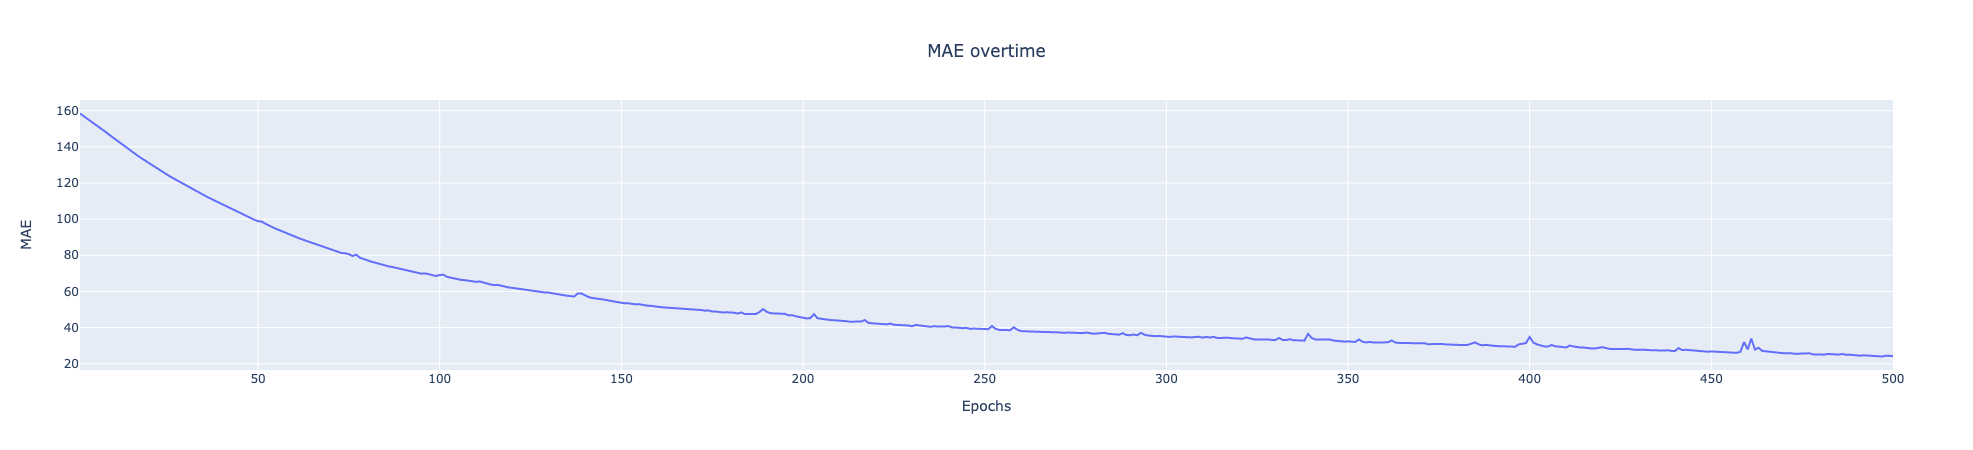

In [152]:
fig = go.Figure(data=go.Scatter(x=list(range(1,len(history.history['mean_absolute_error'])+1)), y = history.history['mean_absolute_error']))
fig.update_layout(title={'text':"MAE overtime", 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Epochs", yaxis_title="MAE")
fig.show()